## Computer Vision (AIRO) Project 4
### Car Plate Recognition and Reconstruction with Deep Learning

## YOLO v8 + PDLPR model
This is the model that has been proposed in the paper [A Real-Time License Plate Detection and Recognition Model in Unconstrained Scenarios](https://www.mdpi.com/1424-8220/24/9/2791). Their proposal is a two-stage plate detection + recognition network using an off-the-shelf detector which would predict where the plate is in the picture and feed the cropped plate to a recognition model of their own invention. Here their model has been proposed as-is with some differences regarding the training method of the recognition model. (Note: test with YOLO v8 bboxes not available because of system issues. Only YOLO training/eval and PDLPR training on GT bboxes and eval are available).

Model type: 2 stage detection+recognition architecture with transformers. No end to end training./
YOLO v8 (from Ultralytics) produces a bounding box around the plate which is then used to crop such plate, resize it to 48x144 and send it to the PDLPR (Parallel Decode License Plate Recognition) algorithm that is composed of an IGFE (Improved Global Feature Extractor) which is a CNN made to extract meaningful features from the plate and then and Encoder-Parallel Decoder transformer architecture is used to generate a representation of the character sequence of the plate and then outputted as a series of readable characters (7x63 2d tensor of probabilities to be softmaxed and processed by a positionwise FCNN which then outputs the highest-probability character sequence).

Training losses used: CIoU/Distribution Focal Loss for box regression, Binary Cross Entropy for detection + Multiclass Cross Entropy for character decoding.

### 1) Includes and Utils

In [12]:
import sys
import os
import contextlib
import torch
import random
from PIL import Image
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, random_split, DataLoader
import torchvision
from torchvision import transforms
import shutil
import matplotlib as mpl
import torchvision.transforms.functional as TF
from torch.nn.utils.rnn import pad_sequence

### 2) Dataset setup

The dataset used is the same as the other two baselines. [CCPD (2019)](https://www.kaggle.com/datasets/binh234/ccpd-preprocess) dataset with the splits suggested by the creators.

In [50]:
import kagglehub

# here we Download the dataset (it xan be exported from google drive if it was downloaded there)
path = kagglehub.dataset_download("binh234/ccpd-preprocess")

print("Path to dataset files:", path)
dataset_path = path + '/CCPD2019/ccpd_base/'

Path to dataset files: /home/dalex/.cache/kagglehub/datasets/binh234/ccpd-preprocess/versions/2


Image: 0389703065134-86_95-146,462_489,580-484,550_166,577_153,481_471,454-0_0_2_31_32_24_32-89-37.jpg
Image: 0168582375479-92_92-194,418_445,491-460,508_210,492_209,414_459,430-0_0_10_31_25_27_33-41-8.jpg
Image: 0151388888889-90_81-296,508_538,588-536,582_319,578_308,500_525,504-0_0_25_27_23_32_24-163-57.jpg
Image: 00856321839081-91_81-275,466_443,528-446,537_278,525_263,457_431,469-0_0_30_31_24_33_28-129-10.jpg
Image: 0157136015326-94_86-333,531_552,622-561,632_347,605_336,530_550,557-0_12_30_8_27_32_33-61-10.jpg
Image: 0147605363985-88_79-295,516_502,595-497,592_300,594_287,521_484,519-0_0_16_28_25_30_16-68-38.jpg
Image: 0138888888889-90_93-225,464_437,541-433,537_228,535_231,468_436,470-11_0_3_27_8_33_31-85-17.jpg



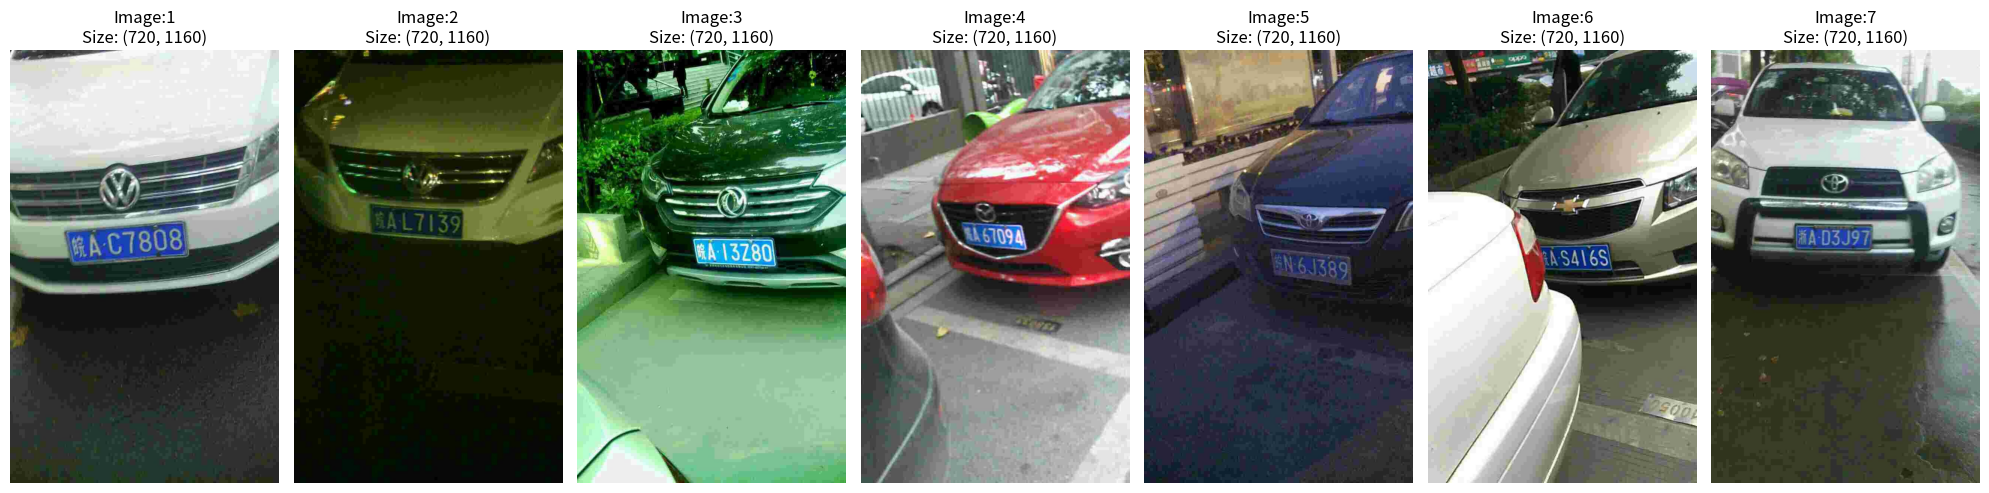

In [51]:
#visuilization some samples
def sample_images(dataset_path,num_of_images):
  image_files = random.sample([img for img in os.listdir(dataset_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))],num_of_images)
  plt.figure(figsize=(20, 6))

  for idx, img_file in enumerate(image_files):
      img_path = os.path.join(dataset_path, img_file)
      try:
            image = Image.open(img_path).convert("RGB")
            print(f"Image: {img_file}")
            plt.subplot(1, num_of_images, idx + 1)
            plt.imshow(image)
            plt.title(f"Image:{idx+1}\nSize: {image.size}")
            plt.axis("off")
      except Exception as e:
            print(f"Error{img_file}: {e}")
  print('')
  plt.tight_layout()
  plt.show()
sample_images(dataset_path,num_of_images=7)

In [16]:
#to extract the bounding box and the other from the image name
class CCPD_Dataset(torch.utils.data.Dataset):
    def __init__(self, dataset_path, image_list, transform=None):
        self.transform = transform
        self.dataset_path = dataset_path
        self.image_files = image_list

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.dataset_path, img_name)
        baseimg = Image.open(img_path)
        orig_w, orig_h = baseimg.size

        if self.transform:
            image = self.transform(baseimg.convert("RGB"))
        else:
            image = baseimg.convert("RGB")

        fields = img_name.split('-')
        box_str = fields[2]
        leftup, rightbottom = box_str.split('_')
        x1, y1 = map(int, leftup.split(','))
        x2, y2 = map(int, rightbottom.split(','))

        x_center = (x1 + x2) / 2 / orig_w
        y_center = (y1 + y2) / 2 / orig_h
        width = (x2 - x1) / orig_w
        height = (y2 - y1) / orig_h

        class_id = 0

        #used later on for the recognition part
        province_to_all_idx = {i: i for i in range(35)}
        alphabet_to_all_idx = {i: i for i in range(26)}
        ads_to_all_idx = {i: i for i in range(36)}

        strcharas = fields[4].split('_')
        charaslist = [int(idx) for idx in strcharas]
        provincecharidx = province_to_all_idx.get(charaslist[0], 0)
        alphabetcharidx = alphabet_to_all_idx.get(charaslist[1], 0)
        adscharidx = []
        for idx in charaslist[2:]:
            adscharidx.append(ads_to_all_idx.get(idx, 0))
        charaslistdef = [provincecharidx, alphabetcharidx] + adscharidx

        return img_name, (class_id, x_center, y_center, width, height)

### 3) Detector Setup, train and evaluation

In [17]:
!pip install ultralytics

import ultralytics
ultralytics.checks() #to verify the versions downloaded

Ultralytics 8.3.161 🚀 Python-3.12.3 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 3070, 8192MiB)
Setup complete ✅ (16 CPUs, 7.7 GB RAM, 112.9/1006.9 GB disk)


In [18]:
def prepare_yolo_dataset(ccpd_dataset_path, output_root_dir, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    # Ensure ratios sum to 1
    if not (train_ratio + val_ratio + test_ratio == 1.0):
        print("the sum is not equal to 1 to solve it i have changed the test ratio")
        test_ratio = 1.0 - train_ratio - val_ratio
        if test_ratio < 0:
            raise ValueError("Invalid ratios: train_ratio + val_ratio is greater than 1.")
        print(f"Adjusted ratios: Train={train_ratio}, Val={val_ratio}, Test={test_ratio}")

    # Create necessary directories used by yolo for images and labels
    # based on a specific architecture specified by the yolo
    train_img_dir = os.path.join(output_root_dir, 'images', 'train')
    train_lbl_dir = os.path.join(output_root_dir, 'labels', 'train')
    val_img_dir = os.path.join(output_root_dir, 'images', 'val')
    val_lbl_dir = os.path.join(output_root_dir, 'labels', 'val')
    test_img_dir = os.path.join(output_root_dir, 'images', 'test')
    test_lbl_dir = os.path.join(output_root_dir, 'labels', 'test')

    os.makedirs(train_img_dir, exist_ok=True)
    os.makedirs(train_lbl_dir, exist_ok=True)
    os.makedirs(val_img_dir, exist_ok=True)
    os.makedirs(val_lbl_dir, exist_ok=True)
    os.makedirs(test_img_dir, exist_ok=True)
    os.makedirs(test_lbl_dir, exist_ok=True)

    # extract all the images and shuffle them (HERE WE CAN ADD SOME ROTATION/ TRANSFORMATION FOR THE IMAGES)
    all_image_files = [f for f in os.listdir(ccpd_dataset_path) if f.endswith('.jpg')]
    random.shuffle(all_image_files)

    total_images = len(all_image_files)
    train_size = int(total_images * train_ratio)
    val_size = int(total_images * val_ratio)
    test_size = total_images - train_size - val_size

    train_files = all_image_files[:train_size]
    val_files = all_image_files[train_size : train_size + val_size]
    test_files = all_image_files[train_size + val_size : ]

    print(f"Total images found: {total_images}")
    print(f"Training images: {len(train_files)}")
    print(f"Validation images: {len(val_files)}")
    print(f"Test images: {len(test_files)}")

    # Use the CCPD_Dataset to parse and generate labels
    temp_dataset = CCPD_Dataset(ccpd_dataset_path, all_image_files)

    # FUNCTION TO TRANSFORM THE DATASET LABES TO A SPECIFIC FORMAT LIKE TXT
    def process_split(files, img_output_dir, lbl_output_dir):
        count = 0
        for img_name in files:
            idx = temp_dataset.image_files.index(img_name)
            _, (class_id, x_center, y_center, width, height) = temp_dataset[idx]

            shutil.copy(os.path.join(ccpd_dataset_path, img_name), os.path.join(img_output_dir, img_name))

            label_filename = img_name.replace(".jpg", ".txt")
            with open(os.path.join(lbl_output_dir, label_filename), 'w') as f:
                f.write(f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")
            count += 1
        return count

    print("Preparing training data...")
    processed_train = process_split(train_files, train_img_dir, train_lbl_dir)
    print(f"Finished preparing {processed_train} training samples.")

    print("Preparing validation data...")
    processed_val = process_split(val_files, val_img_dir, val_lbl_dir)
    print(f"Finished preparing {processed_val} validation samples.")

    print("Preparing test data...")
    processed_test = process_split(test_files, test_img_dir, test_lbl_dir)
    print(f"Finished preparing {processed_test} test samples.")

        # Create data.yaml file, which is used by the yolo to perform the training
    data_yaml_path = os.path.join(output_root_dir, 'data.yaml')
    data_yaml_content = f"""
path: {os.path.abspath(output_root_dir)}
train: images/train
val: images/val
test: images/test
nc: 1
names: ['car_plate']
"""
    with open(data_yaml_path, 'w') as f:
        f.write(data_yaml_content)
    print(f"Created data.yaml at {data_yaml_path}")



# here you should change the dataset path based on the one used in the computer/ colab
dataset_path = dataset_path
output_yolo_dir = '/content/yolo_ccpd_data' # Output directory for YOLO formatted data

if not os.path.exists(dataset_path):
    print(f"Error: Original CCPD dataset path not found: {dataset_path}")
    print("Please check your Google Drive mount and the exact path to your CCPD dataset folder.")
else:
    prepare_yolo_dataset(dataset_path, output_yolo_dir)



PermissionError: [Errno 13] Permission denied: '/content'

In [19]:
from ultralytics import YOLO

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
# now let's train the yolo model
print("we start with training the YOLOv8 Model")

# Load a pre-trained YOLOv8n model (nano version, good starting point)
model = YOLO('yolov8n.pt')

# Training parameters
num_epochs = 2       # Number of training epochs. set to 2 for computational purposes
batch_size = 4       # Number of images per batch. also set to 4 due to computational purposes.
img_size = 640
device = 'cuda' if torch.cuda.is_available() else 'cpu' # remake sure of the use of the gpu

# set names for the project
project_name = 'yolov8_car_plate_detection'
run_name = 'ccpd_detection_run_3split_final'

print(f"Training on device: {device}")
print(f"Input image size: {img_size}x{img_size}")
print(f"Training run name: {run_name} under project: {project_name}")

results = model.train(data=os.path.join(output_yolo_dir, "data.yaml"),
                      epochs=num_epochs,
                      batch=batch_size,
                      imgsz=img_size,
                      device=device,
                      name=run_name,
                      project=project_name,
                      val=True)

print("done")


--- Step 5: Training the YOLOv8 Model ---
Training on device: cuda
Input image size: 640x640
Training run name: ccpd_detection_run_3split_final under project: yolov8_car_plate_detection
Ultralytics 8.3.161 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/yolo_ccpd_data/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=2, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mo

train: Scanning /content/yolo_ccpd_data/labels/train... 181955 images, 0 backgrounds, 0 corrupt: 100%|██████████| 181955/181955 [09:55<00:00, 305.79it/s]


train: New cache created: /content/yolo_ccpd_data/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 1.3±1.7 ms, read: 11.2±3.3 MB/s, size: 71.6 KB)


val: Scanning /content/yolo_ccpd_data/labels/val... 55487 images, 0 backgrounds, 0 corrupt: 100%|██████████| 55487/55487 [02:50<00:00, 325.25it/s]


val: New cache created: /content/yolo_ccpd_data/labels/val.cache
Plotting labels to yolov8_car_plate_detection/ccpd_detection_run_3split_final2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to yolov8_car_plate_detection/ccpd_detection_run_3split_final2
Starting training for 2 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/2     0.592G      1.022     0.5116      1.026         10        640: 100%|██████████| 45489/45489 [1:39:55<00:00,  7.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6936/6936 [10:37<00:00, 10.89it/s]


                   all      55487      55487      0.999          1      0.995      0.774

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/2     0.609G     0.9797     0.3871      1.014         11        640:  15%|█▌        | 6865/45489 [14:27<1:19:51,  8.06it/s]

Here we have tried to crop the resulted images from the yolo in order to be fed for the pdlpr however and due to computational issues, we have not been able to complete this step.

In [ ]:
# Load trained detection model
detection_model = YOLO("yolov8_car_plate_detection/ccpd_detection_run_3split_final/weights/best.pt")

# Run inference on an image (or directory)
results = detection_model("/your/yolo/test/folder", conf=0.5, save=False, task='detect', stream=True)

# If you used stream=True, results is a generator; otherwise, it's a list
for result in results:
    # result.boxes contains all detected boxes
    for box in result.boxes:
        # Get coordinates
        x1, y1, x2, y2 = box.xyxy[0].tolist()  # Bounding box (float)
        # Get confidence score
        conf = box.conf[0].item()
        # Get class id
        cls = int(box.cls[0].item())
        print(f"Box: {x1:.1f},{y1:.1f},{x2:.1f},{y2:.1f} | Conf: {conf:.2f} | Class: {cls}")


image 1/30000 /home/dalex/AIRO_2024-2025/Training_data/yolo_ccpd_data/images/test/00229166666667-90_87-362,438_461,467-458,465_364,463_363,432_457,434-0_0_33_29_30_29_28-164-11.jpg: 640x416 1 car_plate, 8.4ms
Box: 361.0,429.6,457.3,466.1 | Conf: 0.74 | Class: 0
image 2/30000 /home/dalex/AIRO_2024-2025/Training_data/yolo_ccpd_data/images/test/00256944444445-92_87-224,566_311,607-317,602_220,603_218,564_315,563-0_0_24_21_30_29_28-110-8.jpg: 640x416 1 car_plate, 7.4ms
Box: 214.0,562.7,314.2,602.4 | Conf: 0.76 | Class: 0
image 3/30000 /home/dalex/AIRO_2024-2025/Training_data/yolo_ccpd_data/images/test/00283285440614-90_89-294,394_401,426-395,425_301,423_302,389_396,391-0_0_9_17_33_29_26-115-11.jpg: 640x416 1 car_plate, 8.1ms
Box: 298.4,388.6,394.5,424.1 | Conf: 0.72 | Class: 0
image 4/30000 /home/dalex/AIRO_2024-2025/Training_data/yolo_ccpd_data/images/test/00290229885057-90_84-253,510_384,550-368,557_263,556_263,520_368,521-0_0_15_29_30_30_25-121-7.jpg: 640x416 1 car_plate, 7.4ms
Box: 25

KeyboardInterrupt: 

### 4) Recognizer Setup, train and evaluation

In [21]:
# resize in order to be the same size as the input declared for the pdlpr
recognition_transform = transforms.Compose([
    transforms.Resize((48, 144)),
    transforms.ToTensor()
])


In [22]:
# Suggested CCPD-Preprocess character lists:

provinces = ["皖", "沪", "津", "渝", "冀", "晋", "蒙", "辽", "吉", "黑", "苏", "浙", "京", "闽", "赣", "鲁", "豫", "鄂", "湘", "粤", "桂", "琼", "川", "贵", "云", "藏", "陕", "甘", "青", "宁", "新", "警", "学", "O"]
alphabets = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W',
             'X', 'Y', 'Z', 'O']
ads = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X',
       'Y', 'Z', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'O']

# The "O" means "no character".

#For the predicted characters, instead, a different list has to be used with ALL the characters available (The model doesn't
# make distinctions between the three fields of the plate)

all_characters = ["皖", "沪", "津", "渝", "冀", "晋", "蒙", "辽", "吉", "黑", "苏", "浙", "京", "闽", "赣", "鲁", "豫", "鄂", "湘", "粤", "桂", "琼", "川", "贵", "云", "藏", "陕", "甘", "青", "宁", "新", "警", "学", 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W',
             'X', 'Y', 'Z', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', "O"]
print("Number of characters:", len(all_characters))

province_to_all_idx = [all_characters.index(char) for char in provinces]
alphabet_to_all_idx = [all_characters.index(char) for char in alphabets]
ads_to_all_idx = [all_characters.index(char) for char in ads]

def decode_sequence(indices, all_characters):
    return ''.join([all_characters[i] for i in indices if i < len(all_characters) and i != pad_token_id])

char_to_idx = {char: idx for idx, char in enumerate(all_characters)}
idx_to_char = {idx: char for char, idx in char_to_idx.items()}


Number of characters: 68


In [23]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch, pad_token_id):
    # Filter out invalid samples
    batch = [item for item in batch if item is not None and item[0] is not None]

    if not batch:
        return None, None

    images, labels = zip(*batch)
    images = torch.stack(images)  # (B, 3, 48, 144)

    # Pad labels to the same max length
    padded_labels = pad_sequence(labels, batch_first=True, padding_value=pad_token_id)  # (B, T)

    return images, padded_labels

PDLPR model setup:

In [24]:
class Focus(nn.Module):
    #The focus model of the IGFE where it slice and concatenate
    #The usual shape is (B, C, H, W)
    def __init__(self, in_channels, out_channels):
        super(Focus, self).__init__()
        self.conv = nn.Conv2d(in_channels * 4, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.act = nn.LeakyReLU(0.1)

    def forward(self, x):
        top_left = x[..., ::2, ::2]
        top_right = x[..., ::2, 1::2]
        bottom_left = x[..., 1::2, ::2]
        bottom_right = x[..., 1::2, 1::2]
        x = torch.cat([top_left, top_right, bottom_left, bottom_right], dim=1)
        return self.act(self.bn(self.conv(x)))

class ConvDownSampling(nn.Module):
    # as the paper mentioned we need to use conv + BN + LeakyReLU with stride 2 for downsampling
    def __init__(self, in_channels, out_channels):
        super(ConvDownSampling, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.1)
        )

    def forward(self, x):
        return self.block(x)

class ResBlock(nn.Module):
    #the residual block
    def __init__(self, channels):
        super(ResBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(channels),
            nn.LeakyReLU(0.1),
            nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(channels)
        )
        self.act = nn.LeakyReLU(0.1)

    def forward(self, x):
        return self.act(self.block(x) + x)

class IGFE(nn.Module):
    #here we concatenate the blocks as mentioned in the paper
    def __init__(self):
        super(IGFE, self).__init__()
        self.focus = Focus(3, 64)

        self.res1 = ResBlock(64)
        self.res2 = ResBlock(64)
        self.down1 = ConvDownSampling(64, 128)

        self.res3 = ResBlock(128)
        self.res4 = ResBlock(128)
        self.down2 = ConvDownSampling(128, 256)

        self.final_conv = nn.Conv2d(256, 512, kernel_size=1)

    def forward(self, x):
        x = self.focus(x)        # (B, 64, 24, 72)
        x = self.res1(x)
        x = self.res2(x)
        x = self.down1(x)        # (B, 128, 12, 36)
        x = self.res3(x)
        x = self.res4(x)
        x = self.down2(x)        # (B, 256, 6, 18)
        x = self.final_conv(x)   # (B, 512, 6, 18)
        return x



In [25]:
class PositionalEncoding(nn.Module):
    #add trainable parameters as positional embiddings
    def __init__(self, d_model, height, width):
        super(PositionalEncoding, self).__init__()
        self.positionalembeddings = nn.Parameter(torch.randn(1, d_model, height, width))  # (1, C, H, W)

    def forward(self, x):
        return x + self.positionalembeddings


In [26]:
class EncoderBlock(nn.Module):
    def __init__(self, d_model, num_heads):
        super(EncoderBlock, self).__init__()
        self.conv1 = nn.Conv2d(d_model, d_model * 2, kernel_size=1)
        self.attn = nn.MultiheadAttention(d_model * 2, num_heads, batch_first=True)
        self.conv2 = nn.Conv2d(d_model * 2, d_model, kernel_size=1)
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x):
        #x is in the form (B, C, H, W)
        B, C, H, W = x.shape
        x = self.conv1(x)                      # (B, C*2, H, W)
        x_flat = x.flatten(2).permute(0, 2, 1) # (B, H*W, C*2)  HERE WE SHOULD PERFORM Permute to do attention block
        attn_out, _ = self.attn(x_flat, x_flat, x_flat)  # (B, H*W, C*2)
        attn_out = attn_out.permute(0, 2, 1).view(B, C * 2, H, W)
        x = self.conv2(attn_out)               # (B, C, H, W)
        x = x + self.norm(x.flatten(2).transpose(1, 2)).transpose(1, 2).view(B, C, H, W)
        return x


In [27]:
#here we concatenate the pre prepared blocks
class Encoder(nn.Module):
    def __init__(self, d_model=512, num_heads=8, num_layers=3):
        super(Encoder, self).__init__()
        self.pos_enc = PositionalEncoding(d_model, height=6, width=18)
        self.layers = nn.ModuleList([
            EncoderBlock(d_model, num_heads) for _ in range(num_layers)
        ])

    def forward(self, x):
        x = self.pos_enc(x)
        for layer in self.layers:
            x = layer(x)
        return x  # (B, 512, 6, 18)


In [28]:
class FeedForward(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.ff = nn.Sequential(
            nn.Linear(d_model, d_model * 4),
            nn.ReLU(),
            nn.Linear(d_model * 4, d_model)
        )

    def forward(self, x):
        return self.ff(x)


In [29]:
class DecoderBlock(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(d_model, num_heads, batch_first=True)
        self.cross_attn = nn.MultiheadAttention(d_model, num_heads, batch_first=True)
        self.ff = FeedForward(d_model)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)

    def forward(self, targetSeq, memory, targetseq_mask=None):
        # Self-attention with mask
        local_targetSeq, _ = self.self_attn(targetSeq, targetSeq, targetSeq, attn_mask=targetseq_mask)
        targetSeq = self.norm1(targetSeq + local_targetSeq)

        # Cross-attention with encoder output (memory)
        local_targetSeq, _ = self.cross_attn(targetSeq, memory, memory)
        targetSeq = self.norm2(targetSeq + local_targetSeq)

        # Feedforward
        local_targetSeq = self.ff(targetSeq)
        targetSeq = self.norm3(targetSeq + local_targetSeq)

        return targetSeq


In [30]:
class ParallelDecoder(nn.Module):
    def __init__(self, d_model=512, num_heads=8, num_layers=3, max_seq_len=18, num_classes=len(all_characters)):
        super().__init__()
        self.char_embed = nn.Embedding(num_classes, d_model)
        self.pos_embed = nn.Parameter(torch.randn(1, max_seq_len, d_model))
        self.memory_proj = nn.Linear(d_model, d_model * 2)
        self.decoder_layers = nn.ModuleList([
            DecoderBlock(d_model * 2, num_heads) for _ in range(num_layers)
        ])
        self.output_proj = nn.Linear(d_model * 2, num_classes)

    def forward(self, memory, tgt_seq, tgt_mask=None):
        seq_len = tgt_seq.size(1)
        tgt = self.char_embed(tgt_seq) + self.pos_embed[:, :seq_len, :]  # (B, T, d_model)
        memory_mean = memory.mean(dim=1, keepdim=False)  # (B, d_model)
        memory_expanded = memory_mean.unsqueeze(1).expand(-1, seq_len, -1)  # (B, T, d_model)
        memory_expanded_proj = self.memory_proj(memory_expanded)  # (B, T, d_model*2)
        concat = torch.cat([tgt, memory_expanded], dim=-1)  # (B, T, d_model*2)

        out = concat
        for layer in self.decoder_layers:
            out = layer(out, memory_expanded_proj, tgt_mask)  # <-- FIXED: use projected memory

        return self.output_proj(out)


In [31]:
class PDLPR(nn.Module):
    def __init__(self, num_classes, d_model=512, num_heads=8, num_layers=3, max_seq_len=18):
        super(PDLPR, self).__init__()
        self.igfe = IGFE()  # Feature extractor
        self.encoder = Encoder(d_model=d_model, num_heads=num_heads, num_layers=num_layers)
        self.decoder = ParallelDecoder(
            d_model=d_model,
            num_heads=num_heads,
            num_layers=num_layers,
            max_seq_len=max_seq_len,
            num_classes=num_classes
        )
        self.max_seq_len = max_seq_len

    def forward(self, images, tgt_seq, tgt_mask=None):
        features = self.igfe(images)  # (B, 512, 6, 18)
        enc_out = self.encoder(features)  # (B, 512, 6, 18)
        B, C, H, W = enc_out.shape
        memory = enc_out.view(B, C, H * W).permute(0, 2, 1)  # (B, 108, 512)
        logits = self.decoder(memory, tgt_seq, tgt_mask)  # (B, max_seq_len, num_classes)
        return logits


In [32]:
def inspect_batch(train_loader, all_characters, idx_to_char):
    batch = next(iter(train_loader))
    images, targets = batch
    print(f"Batch size: {len(images)}")
    for i in range(min(3, len(images))):  # Show up to 3 samples
        img = images[i]
        target = targets[i]
        # Show image
        img_np = img.permute(1,2,0).cpu().numpy()
        img_np = (img_np * 0.5 + 0.5).clip(0,1)
        plt.figure(figsize=(4,4))
        plt.imshow(img_np)
        # Draw bbox
        box = target['boxes'][0].cpu().numpy()
        x1, y1, x2, y2 = box
        plt.gca().add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, color='red', linewidth=2))
        plt.title("Sample image with GT bbox")
        plt.axis('off')
        plt.show()
        # Print char sequence
        char_indices = target['charas'][0].cpu().tolist()
        char_str = ''.join([idx_to_char[idx] for idx in char_indices])
        print(f"GT char indices: {char_indices}")
        print(f"GT char string: {char_str}")

Now setting up PDLPR training with GT bounding boxes only.

For this model, several attempts at including seamlessly YOLO failed because of how YOLOv8 from ultralytics handles data, causing compatibility issues with PDLPR (made with torch) and requiring a full preprocessing of the whole 15GB+ of data, which causes repeated crashes of VSCode. Usage of other detection models offered results far from the par. On further analysis, YOLOv8 offered cropped plates which had a IoU of >0.8 on average, so usage of GT bboxes should give the same performances. Moreover, training on GT bboxes before is often a good technique to teach meaningful features to the recognizer before passing on more noisy inputs to help generalization and reduce overfitting.

The new dataset class to use:

In [52]:
# Re-set directory path
path = kagglehub.dataset_download("binh234/ccpd-preprocess")

print("Path to dataset files:", path)
dataset_path=path+'/CCPD2019/'

Path to dataset files: /home/dalex/.cache/kagglehub/datasets/binh234/ccpd-preprocess/versions/2


In [53]:
def read_split_file(split_file_path):
    with open(split_file_path, 'r') as f:
        return [line.strip() for line in f if line.strip()]

# Paths to split files
split_dir = os.path.join(path, "CCPD2019/splits")  # adjust if needed
train_list = read_split_file(os.path.join(split_dir, "train.txt"))
val_list = read_split_file(os.path.join(split_dir, "val.txt"))
test_list = read_split_file(os.path.join(split_dir, "test.txt"))

In [54]:
class CCPD_GT_CroppedPlates(torch.utils.data.Dataset):
    def __init__(self, dataset_path, image_list, transform=None):
        self.dataset_path = dataset_path
        self.image_list = image_list
        self.transform = transform

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        img_name = self.image_list[idx]
        img_path = os.path.join(self.dataset_path, img_name)
        image = Image.open(img_path).convert("RGB")
        fields = img_name.split('-')
        box_str = fields[2]
        leftup, rightbottom = box_str.split('_')
        x1, y1 = map(int, leftup.split(','))
        x2, y2 = map(int, rightbottom.split(','))
        # Crop plate using GT box
        cropped = image.crop((x1, y1, x2, y2))
        if self.transform:
            cropped = self.transform(cropped)
        # Prepare label as before
        strcharas = fields[4].split('_')
        charaslist = [int(idx) for idx in strcharas]
        provincecharidx = province_to_all_idx[charaslist[0]]
        alphabetcharidx = alphabet_to_all_idx[charaslist[1]]
        adscharidx = [ads_to_all_idx[idx] for idx in charaslist[2:]]
        label = [provincecharidx, alphabetcharidx] + adscharidx
        return cropped, torch.tensor(label, dtype=torch.long)

#  set the data loader train and validate

train_dataset = CCPD_GT_CroppedPlates(
    dataset_path=dataset_path,
    image_list=train_list,
    transform=recognition_transform
)
val_dataset = CCPD_GT_CroppedPlates(
    dataset_path=dataset_path,
    image_list=val_list,
    transform=recognition_transform
)
test_dataset = CCPD_GT_CroppedPlates(
    dataset_path=dataset_path,
    image_list=test_list,
    transform=recognition_transform
)

def collate_fn_gt(batch, pad_token_id):
    batch = [item for item in batch if item is not None and item[0] is not None]
    if not batch:
        return None, None
    images, labels = zip(*batch)
    images = torch.stack(images)
    padded_labels = pad_sequence(labels, batch_first=True, padding_value=pad_token_id)
    return images, padded_labels

pad_token_id = char_to_idx["O"]
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=32, shuffle=True,
    collate_fn=lambda b: collate_fn_gt(b, pad_token_id)
)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=32, shuffle=False,
    collate_fn=lambda b: collate_fn_gt(b, pad_token_id)
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=32, shuffle=False,
    collate_fn=lambda b: collate_fn_gt(b, pad_token_id)
)

Training + eval loop

In [ ]:
model = PDLPR(num_classes=len(all_characters)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    print(f"\n🟢 Starting Epoch {epoch + 1}/{num_epochs}")
    for step, (images, labels) in enumerate(train_loader):
        if images is None:
            continue
        images = images.to(device)
        labels = labels.to(device)
        start_token = torch.full((labels.size(0), 1), pad_token_id, dtype=torch.long, device=labels.device)
        decoder_input = torch.cat([start_token, labels[:, :-1]], dim=1)
        decoder_target = labels
        logits = model(images, decoder_input)
        loss = F.cross_entropy(
            logits.reshape(-1, logits.size(-1)),
            decoder_target.reshape(-1),
            ignore_index=pad_token_id
        )
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        if step % 300 == 0:
            print(f"  Step {step} | Loss: {loss.item():.4f}")
    print(f"Epoch {epoch+1} - Loss: {total_loss / len(train_loader):.4f}")
    torch.save(model.state_dict(), f"pdlpr_gtcrop_epoch_{epoch+1}.pth")


    model.eval()
    val_loss = 0
    num_batches = 0
    with torch.no_grad():
        for val_images, val_labels in val_loader:
            if val_images is None:
                continue
            val_images = val_images.to(device)
            val_labels = val_labels.to(device)
            start_token = torch.full((val_labels.size(0), 1), pad_token_id, dtype=torch.long, device=val_labels.device)
            decoder_input = torch.cat([start_token, val_labels[:, :-1]], dim=1)
            decoder_target = val_labels
            logits = model(val_images, decoder_input)
            loss = F.cross_entropy(
                logits.reshape(-1, logits.size(-1)),
                decoder_target.reshape(-1),
                ignore_index=pad_token_id
            )
            val_loss += loss.item()
            num_batches += 1

            # Optionally print a few predictions
            if num_batches == 1:
                pred = logits.argmax(dim=-1)
                for i in range(min(2, pred.size(0))):
                    pred_text = decode_sequence(pred[i].tolist(), all_characters)
                    target_text = decode_sequence(decoder_target[i].tolist(), all_characters)
                    print(f"\n[VAL] Sample {i+1}")
                    print("🟩 Prediction :", pred_text)
                    print("🟥 GroundTruth:", target_text)

    avg_val_loss = val_loss / max(1, num_batches)
    print(f"Epoch {epoch+1} - Validation Loss: {avg_val_loss:.4f}")
    
    


🟢 Starting Epoch 1/5
  Step 0 | Loss: 4.3764
  Step 300 | Loss: 0.3794
  Step 600 | Loss: 0.1990
  Step 900 | Loss: 0.0295
  Step 1200 | Loss: 0.0501
  Step 1500 | Loss: 0.0332
  Step 1800 | Loss: 0.0145
  Step 2100 | Loss: 0.0638
  Step 2400 | Loss: 0.0019
  Step 2700 | Loss: 0.0440
  Step 3000 | Loss: 0.0027
Epoch 1 - Loss: 0.1424

[VAL] Sample 1
🟩 Prediction : 皖AB1120
🟥 GroundTruth: 皖AB112D

[VAL] Sample 2
🟩 Prediction : 皖APV930
🟥 GroundTruth: 皖APV930
Epoch 1 - Validation Loss: 0.0205

🟢 Starting Epoch 2/5
  Step 0 | Loss: 0.0143
  Step 300 | Loss: 0.0027
  Step 600 | Loss: 0.0225
  Step 900 | Loss: 0.0061
  Step 1200 | Loss: 0.0112
  Step 1500 | Loss: 0.0124
  Step 1800 | Loss: 0.0181
  Step 2100 | Loss: 0.0015
  Step 2400 | Loss: 0.0060
  Step 2700 | Loss: 0.0021
  Step 3000 | Loss: 0.0005
Epoch 2 - Loss: 0.0138

[VAL] Sample 1
🟩 Prediction : 皖AB112D
🟥 GroundTruth: 皖AB112D

[VAL] Sample 2
🟩 Prediction : 皖APV930
🟥 GroundTruth: 皖APV930
Epoch 2 - Validation Loss: 0.0143

🟢 Starting 

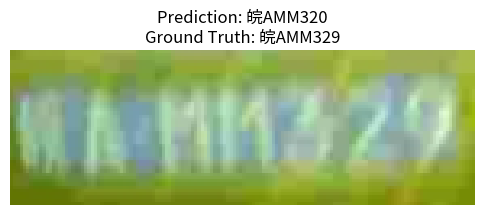

Sample 1 - Prediction: 皖AMM320, Ground Truth: 皖AMM329


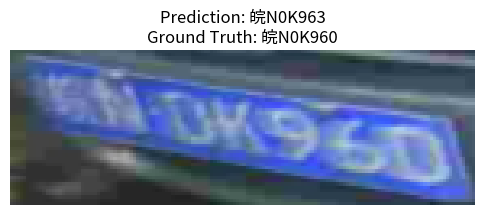

Sample 2 - Prediction: 皖N0K963, Ground Truth: 皖N0K960


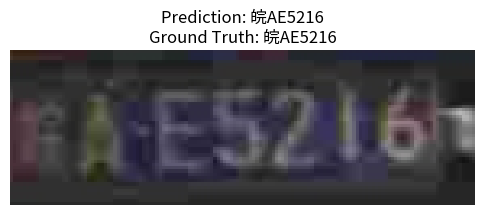

Sample 3 - Prediction: 皖AE5216, Ground Truth: 皖AE5216


In [55]:
#  Testing on single samples
def visualize_single_test_samples(dataset, model, all_characters, num_samples=3):
    model.eval()
    mpl.rcParams['font.family'] = 'Noto Sans CJK JP'
    mpl.rcParams['axes.unicode_minus'] = False

    for i in range(num_samples):
        idx = random.randint(0, len(dataset) - 1)
        image, target = dataset[idx]
        if image is None or target is None:
            continue

        # Extract label tensor from dict
        if isinstance(target, dict):
            label = target['charas'].squeeze(0)
        else:
            label = target

        with torch.no_grad():
            image_input = image.unsqueeze(0).to(device)
            label_input = label.unsqueeze(0).to(device)
            start_token = torch.full((1, 1), pad_token_id, dtype=torch.long, device=device)
            decoder_input = torch.cat([start_token, label_input[:, :-1]], dim=1)
            logits = model(image_input, decoder_input)
            pred = logits.argmax(dim=-1)[0].cpu().tolist()

        pred_text = decode_sequence(pred, all_characters)
        true_text = decode_sequence(label.tolist(), all_characters)

        plt.figure(figsize=(6, 4))
        plt.imshow(image.permute(1, 2, 0).cpu())
        plt.title(f"Prediction: {pred_text}\nGround Truth: {true_text}")
        plt.axis('off')
        plt.show()
        print(f"Sample {i+1} - Prediction: {pred_text}, Ground Truth: {true_text}")

model = PDLPR(num_classes=len(all_characters)).to(device)
model.load_state_dict(torch.load('pdlpr_gtcrop_epoch_4.pth', map_location=device))
# Example usage:
visualize_single_test_samples(test_dataset, model, all_characters, num_samples=3)